# Fine-tuning Florence-2 for Object Detection using Maestro

---

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/maestro/blob/develop/cookbooks/maestro_florence_2_object_detection.ipynb)
[![dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/poker-cards-fmjio)

## Environment setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `A100 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Feb  5 15:08:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q maestro[florence_2] roboflow

## Download and prepare dataset

The dataset is sourced from Roboflow and is structured in JSONL format. Using the Roboflow API, we authenticate, select a workspace and project, and download the dataset.


In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("roboflow-jvuqo")
project = workspace.project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("florence2-od")

In [4]:
!head -n 1 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack  of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}


## Train Florence-2 with maestro

The training process is initiated using Maestro's `train` function. The training is run using 5 epochs with a batch size of 8. The optimization strategy used is `lora`, which allows for efficient fine-tuning of large models. The metric tracked during training is `edit_distance`.

In [ ]:
from maestro.trainer.models.florence_2.core import train

config = {
    "model_id": "microsoft/Florence-2-large-ft",
    "dataset": dataset.location,
    "epochs": 10,
    "batch_size": 4,
    "num_workers": 10,
    "optimization_strategy": "lora",
    "metrics": ["edit_distance"],
}

train(config)

## Examine training results

After training, we examine the results by listing available metric files and visualizing the loss, edit distance, and BLEU plots. These metrics help assess model performance, tracking how well the model aligns with ground truth JSON extractions.


In [6]:
!ls -la /content/training/florence_2/1/metrics

total 72
drwxr-xr-x 2 root root  4096 Feb  5 15:51 .
drwxr-xr-x 4 root root  4096 Feb  5 15:51 ..
-rw-r--r-- 1 root root 30171 Feb  5 15:51 edit_distance_plot.png
-rw-r--r-- 1 root root 29407 Feb  5 15:51 loss_plot.png


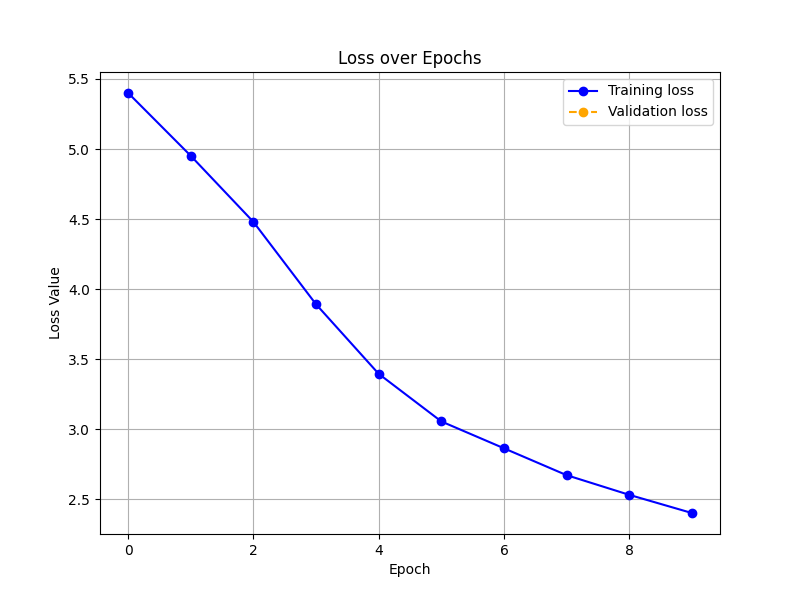

In [7]:
from IPython.display import Image

Image(filename="/content/training/florence_2/1/metrics/loss_plot.png", height=600)

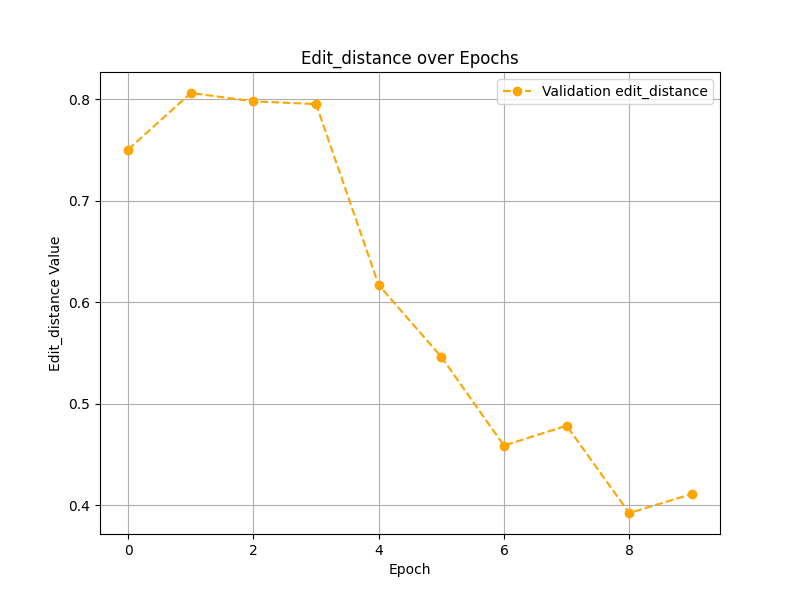

In [8]:
from IPython.display import Image

Image(filename="/content/training/florence_2/1/metrics/edit_distance_plot.png", height=600)

## Run inference with fine-tuned Florence-2 model

We load the fine-tuned Florence-2 model and run inference on test images. The `predict` function generates detections, ready to be visualized on the image.


In [9]:
from maestro.trainer.models.florence_2.checkpoints import OptimizationStrategy, load_model

processor, model = load_model(
    model_id_or_path="/content/training/florence_2/1/checkpoints/latest",
    optimization_strategy=OptimizationStrategy.NONE,
)

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [10]:
from maestro.trainer.common.datasets import RoboflowJSONLDataset

ds = RoboflowJSONLDataset(
    jsonl_file_path=f"{dataset.location}/test/annotations.jsonl",
    image_directory_path=f"{dataset.location}/test",
)

image, entry = ds[0]

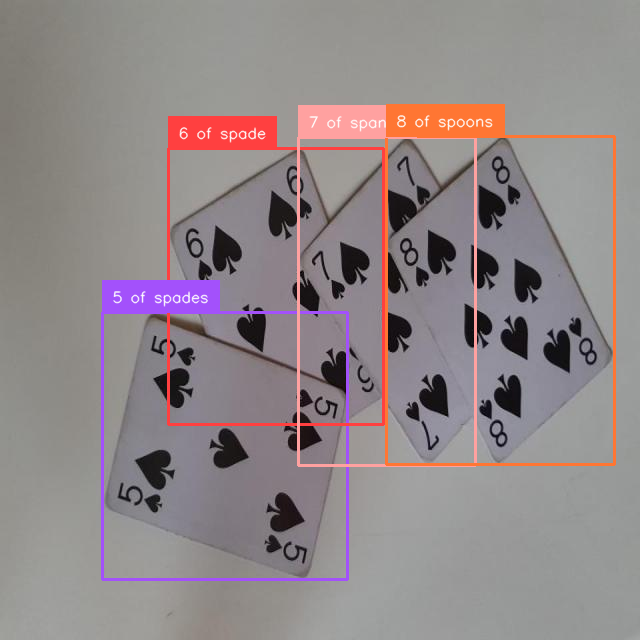

In [17]:
import supervision as sv

from maestro.trainer.models.florence_2.inference import predict

generated_text = predict(model=model, processor=processor, image=image, prefix=entry["prefix"])
result = processor.post_process_generation(text=generated_text, task="<OD>", image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(lmm=sv.LMM.FLORENCE_2, result=result, resolution_wh=image.size)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(
    scene=annotated_image, detections=detections
)
annotated_image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(
    scene=annotated_image, detections=detections
)
annotated_image

## More Vision-Language Models

Now that you have fine-tuned Florence-2 for object detection, why not experiment with other vision-language models and different vision tasks? You can explore more at [Maestro Documentation](https://maestro.roboflow.com/) or the [Maestro GitHub](https://github.com/roboflow/maestro). If you find a bug or have feature ideas, submit an issue at [GitHub Issues](https://github.com/roboflow/maestro/issues).
